In [7]:
import os
import pandas as pd

rename_map = {
    # ===== Predict-then-Optimize baselines =====
    "LinearNNSoftmax_softmax_rolling_20251220_0149“maxreturn”": "Softmax-MaxReturn",
    "LinearNNSoftmax_softmax_rolling_20251222_1806“maxsharpe”": "Softmax-MaxSharpe",
    # ===== Robust SPO =====
    "LinearRobustSPO_linear_rolling_20251224_1830“RobustSPO”": "RobustSPO",
    # ===== SPO+ variants =====
    "LinearSPO+_linear_rolling_20251223_1614“markowitzPO”": "PtO Markowitz",
    "LinearSPO+_linear_rolling_20251224_2011“gamma=0.005”": "SPO+ with Fee (γ=0.005)",
    "LinearSPO+_linear_rolling_20251224_2311“gamma=0.005,lambda=0.42”": "SPO+ with turnover penalty(γ=0.005, λ=0.42)",
    # ===== Tuned SPO+ =====
    "LinearSPO+_rolling_optuna_20251220_0037": "SPO+",
}

In [8]:
# ===== 1. 设置你的父目录 =====
ROOT_DIR = r"D:\SPO4Portfolio\outputs"  # ← 改成你的路径

# 用来存每个实验的 nav 序列
nav_dict = {}

# ===== 2. 遍历所有子文件夹 =====
for exp_name in os.listdir(ROOT_DIR):
    exp_path = os.path.join(ROOT_DIR, exp_name)

    if not os.path.isdir(exp_path):
        continue

    csv_path = os.path.join(exp_path, "rolling_performance.csv")

    if not os.path.exists(csv_path):
        continue

    # ===== 3. 读取 rolling_performance.csv =====
    df = pd.read_csv(csv_path)

    if "nav" not in df.columns:
        print(f"[跳过] {exp_name} 没有 nav 列")
        continue

    # 如果有 date 列，设为 index（推荐）
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")

    # 存入字典（key = 实验名，value = nav Series）
    nav_dict[exp_name] = df["nav"]

# ===== 4. 合并成一个 DataFrame =====
nav_df = pd.concat(nav_dict, axis=1)
nav_df = nav_df.rename(columns=rename_map)

display(nav_df)  # 如果在 Jupyter Notebook 中运行，可以看到表格

,Softmax-MaxReturn,Softmax-MaxSharpe,LinearRobustSPO_linear_rolling_20251224_1830”RobustSPO“,PtO Markowitz,SPO+ with Fee (γ=0.005),"LinearSPO+_linear_rolling_20251224_2311”gamma=0.005,lambda=0.42“",SPO+
0,0.990233,1.001032,0.990196,1.002102,0.997398,0.997398,0.997398
1,0.974395,0.991854,0.974359,0.993761,0.985096,0.985096,0.985096
2,0.969849,0.980598,0.969834,0.975492,0.955997,0.955997,0.955997
3,0.965309,0.974594,0.965309,0.968713,0.948427,0.948427,0.948427
4,0.938950,0.968249,0.938914,0.969817,0.954577,0.954577,0.954577
...,...,...,...,...,...,...,...
2075,1.382530,1.112095,2.113545,2.042379,2.271909,1.860000,2.941338
2076,1.386404,1.113168,2.115951,2.052924,2.274494,1.877654,2.944686
2077,1.393685,1.120882,2.117482,2.056054,2.276140,1.876425,2.946816
2078,1.391784,1.122702,2.113108,2.048163,2.271439,1.858949,2.940729


<Axes: >

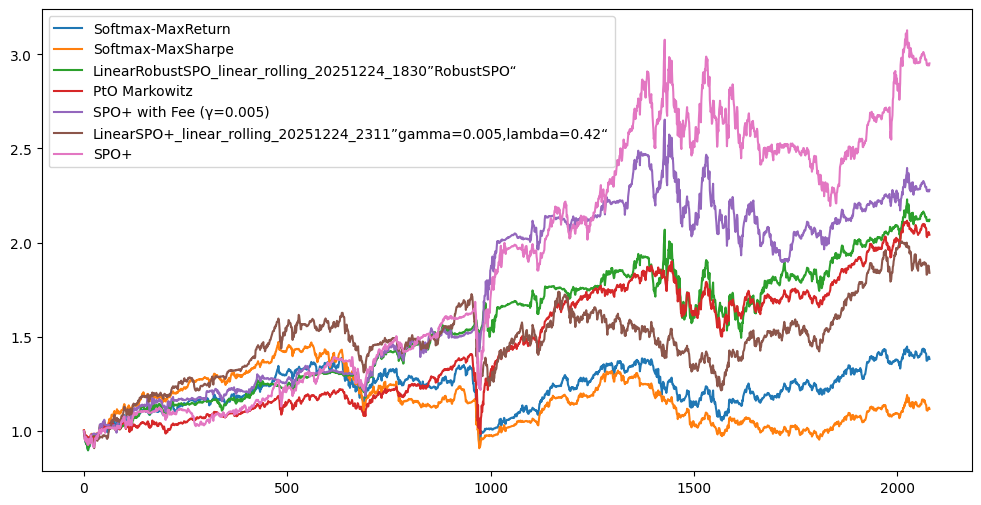

In [9]:
nav_df.plot(figsize=(12, 6))